En este notebook, entrenamos modelos de predicción de discursos de odio en base a distintos datasets, para poder predecir su uso en reddit.

Para obtener los conjuntos de datos, descargarlos desde **TODO**.

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


import spacy

from preprocessing_utils import give_emoji_free_text, url_free_text, \
email_free_text, quotes_free_text, get_lemmas, tokenize, preprocess_corpus

nlp = spacy.load("es_core_news_lg")
np.random.seed(42)
palabras_odio = pd.DataFrame(columns=['hateval_rf', 'hateval_nb', 
                                      'detoxis_rf', 'detoxis_nb', 
                                      'meoffendmex_rf', 'meoffendmex_nb'])

## Dataset HatEval (SemEval 2019 Task5)

- Paper: https://aclanthology.org/S19-2007/
- Web: https://competitions.codalab.org/competitions/19935
- Formulario para acceder a los datos: http://hatespeech.di.unito.it/hateval.html

### Descripción

Este dataset consiste en ~7000 Tweets, que posiblemente representen discurso de odio hacia mujeres o inmigrantes.

El dataset está formado por 5 columnas, representando cada una:

1. ID del Tweet.
1. El texto del Tweet.
1. HS (*hate speech*): si el discurso de odio ocurre contra mujeres o inmigrantes.
1. TR (*target*): si HS=1, recibe un valor de 0 si el discurso de odio es contra un grupo genérico, o un valor de 1 si es específicamente contra un individuo.
1. AG (*aggresive*): si HS=1, indica si quien escribe el Tweet exhibe comportamiento agresivo (si es así: 1; en caso contrario: 0).

([fuente](https://competitions.codalab.org/competitions/19935#participate))


In [2]:
verbose = 1
verbose_dataset = 0
verbose_hate_words = 0

In [3]:
# cargamos el dataset y vemos su información

hate_eval = pd.read_csv('docs/hateval2019/hateval2019_es_train.csv')
print(hate_eval.describe())

                id           HS           TR           AG
count   4500.00000  4500.000000  4500.000000  4500.000000
mean   22507.03400     0.412667     0.250889     0.333778
std     1444.00945     0.492369     0.433573     0.471614
min    20001.00000     0.000000     0.000000     0.000000
25%    21263.50000     0.000000     0.000000     0.000000
50%    22509.50000     0.000000     0.000000     0.000000
75%    23759.25000     1.000000     1.000000     1.000000
max    25000.00000     1.000000     1.000000     1.000000


In [4]:
if verbose_dataset:
    print(hate_eval[hate_eval['HS']==1])

In [5]:
print('Cantidad de Tweets sin HS: {} \nCantidad de Tweets con HS: {}'.format(
    len(hate_eval[hate_eval['HS']==0]), len(hate_eval[hate_eval['HS']==1])))

Cantidad de Tweets sin HS: 2643 
Cantidad de Tweets con HS: 1857


In [6]:
print(hate_eval['id'])

0       20001
1       20002
2       20003
3       20004
4       20007
        ...  
4495    24996
4496    24997
4497    24998
4498    24999
4499    25000
Name: id, Length: 4500, dtype: int64


## Dataset DETOXIS (IberLEF 2021)

- Web: https://detoxisiberlef.wixsite.com/website/corpus
- Formulario para acceder a los datos: https://forms.office.com/r/6csEeBW0w3

### Descripción

Este es un dataset con cerca de 3500 comentarios de sitios de noticias/foros españoles, que posiblemente contienen toxicidad.

El dataset está formado por **TODO** columnas, representando cada una:

1. **TODO**.


In [7]:
# cargamos detoxis dataset

detoxis = pd.read_csv('docs/detoxis_data/train.csv')
if verbose_dataset:
    print(detoxis.describe())

In [8]:
if verbose_dataset:
    print(detoxis[detoxis['negative_stance']==1])

## Dataset MeOffendMex (Iberlef **TODO**)

Paper: **TODO**

- Web: https://competitions.codalab.org/competitions/28679
- Paper: https://rua.ua.es/dspace/bitstream/10045/117506/1/PLN_67_16.pdf
- Repositorio: https://github.com/pendrag/MeOffendEs


### Descripción

Este dataset consiste en alrededor 5000 tweets de usuarios de México, que posiblemente contienen mensajes ofensivos.

El dataset está formado por **TODO** columnas, representando cada una:

1. **TODO**


In [9]:
# cargamos MeOffendMex dataset

meoffendmex = pd.read_csv('docs/MeOffendEs/mx-train-data-non-contextual.csv')
y_meoffendmex = pd.read_csv('docs/MeOffendEs/mx-train-outputs.sol', header=None) 

if verbose_dataset:
    print(meoffendmex.describe())

In [10]:
if verbose_dataset:
    print(meoffendmex.head())

# Procesamos y entrenamos cada uno de los datasets

Definimos la función general de entrenamiento, que lee un conjunto de datos, lo vectoriza y entrena un modelo a partir de dicha vectorización, mostrando las métricas generales del mismo.

In [11]:
def process_training_pipeline(dataset, vectorizer, labels, model):
    vectorized_corpus = vectorizer.fit_transform(dataset)
    X_tr, X_val, y_tr, y_val = train_test_split(vectorized_corpus, labels, test_size=0.3, random_state=42)
    model.fit(X_tr, y_tr)

    print('Tasa de aciertos del clasificador: {} (train), {} (val)'.format(model.score(X_tr, y_tr),
                                                                  model.score(X_val, y_val)))
    print('\nMétricas (train)')
    #print(classification_report(X_tr, y_tr))
    print('Matriz de confusión (train)')
    plot_confusion_matrix(model, X_tr, y_tr,
                          cmap=plt.cm.Blues, 
                          normalize='true')
    plt.show()
    print('\nMétricas (val)')
    #print(classification_report(X_val, y_val))
    print('Matriz de confusión (val)')
    plot_confusion_matrix(model, X_val, y_val,
                          cmap=plt.cm.Blues, 
                          normalize='true')
    plt.show()
    

### Hateval dataset

In [12]:
hateval_corpus_lines = preprocess_corpus(hate_eval['text'])

In [13]:
y_hateval = hate_eval['HS'].values

In [14]:
cv_hateval = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_hateval = LogisticRegression(random_state=42)
nb_hateval = ComplementNB()
rf_hateval = RandomForestClassifier(random_state=42)

Tasa de aciertos del clasificador: 0.9257142857142857 (train), 0.8051851851851852 (val)

Métricas (train)
Matriz de confusión (train)


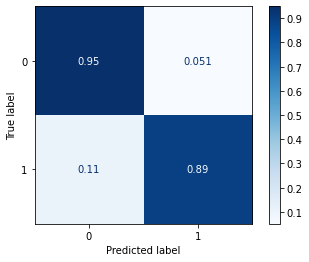


Métricas (val)
Matriz de confusión (val)


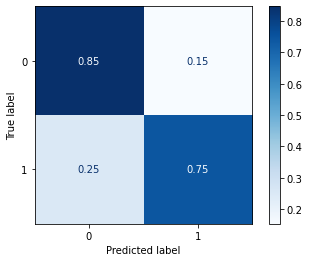

In [15]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          lg_hateval
                         )

Tasa de aciertos del clasificador: 0.9996825396825397 (train), 0.8007407407407408 (val)

Métricas (train)
Matriz de confusión (train)


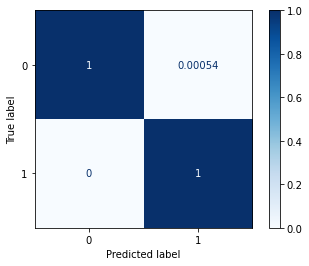


Métricas (val)
Matriz de confusión (val)


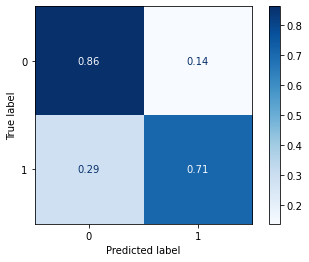

In [16]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          rf_hateval
                         )

In [17]:
if verbose_dataset:
    print(cv_hateval.get_feature_names()[:5])

In [18]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_hateval_idx = rf_hateval.feature_importances_.argsort()[::-1]
palabras_odio_rf_hateval = np.array(cv_hateval.get_feature_names())[rf_features_hateval_idx[:100]]
palabras_odio['hateval_rf'] = pd.Series(palabras_odio_rf_hateval)

if verbose_hate_words:
    print(palabras_odio_rf_hateval)
    print(rf_hateval.feature_importances_[rf_features_hateval_idx[:30]])

Tasa de aciertos del clasificador: 0.8368253968253968 (train), 0.7703703703703704 (val)

Métricas (train)
Matriz de confusión (train)


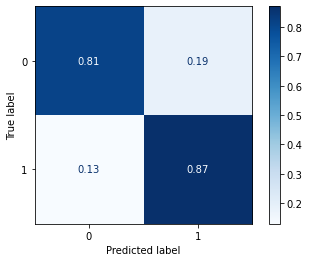


Métricas (val)
Matriz de confusión (val)


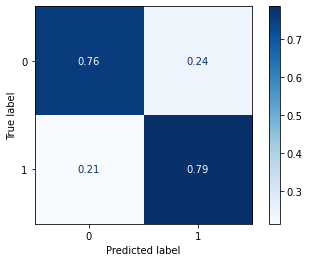

In [19]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          nb_hateval
                         )

In [20]:
# basado en https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
pos_class_prob_sorted = nb_hateval.feature_log_prob_[1, :].argsort()[::-1]
palabras_odio_nb_hateval = np.take(cv_hateval.get_feature_names(), pos_class_prob_sorted[:100])
palabras_odio['hateval_nb'] = pd.Series(palabras_odio_nb_hateval)

if verbose_hate_words:
    print(palabras_odio_nb_hateval)

In [21]:
# guardamos el vectorizador y los modelos entrenados

with open('docs/models/hateval_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv_hateval, file)

with open('docs/models/hateval_lg_model.pkl', 'wb') as file:
    pickle.dump(lg_hateval, file)

with open('docs/models/hateval_nb_model.pkl', 'wb') as file:
    pickle.dump(nb_hateval, file)

with open('docs/models/hateval_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_hateval, file)
    

## Detoxis dataset

In [22]:
detoxis_corpus_lines = preprocess_corpus(detoxis['comment'])
y_detoxis = detoxis['aggressiveness']

In [23]:
y_detoxis[detoxis['aggressiveness']==1]

2       1
5       1
10      1
29      1
32      1
       ..
3280    1
3288    1
3289    1
3291    1
3295    1
Name: aggressiveness, Length: 114, dtype: int64

In [24]:
cv_detoxis = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_detoxis = LogisticRegression(random_state=42)
nb_detoxis = ComplementNB()
rf_detoxis = RandomForestClassifier(random_state=42)

Tasa de aciertos del clasificador: 0.9913366336633663 (train), 0.958614051973051 (val)

Métricas (train)
Matriz de confusión (train)


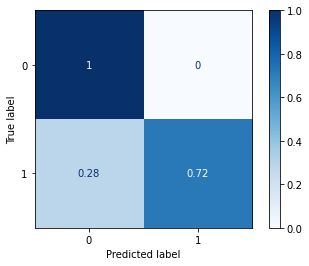


Métricas (val)
Matriz de confusión (val)


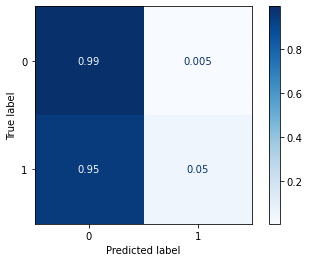

In [25]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          lg_detoxis
                         )

Tasa de aciertos del clasificador: 0.9995874587458746 (train), 0.9615014436958614 (val)

Métricas (train)
Matriz de confusión (train)


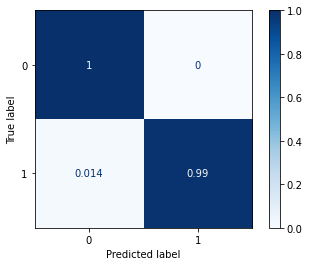


Métricas (val)
Matriz de confusión (val)


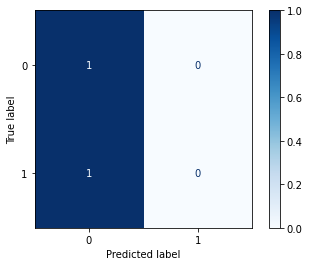

In [26]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          rf_detoxis
                         )

In [27]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_detoxis_idx = rf_detoxis.feature_importances_.argsort()[::-1]
palabras_odio_rf_detoxis = np.array(cv_detoxis.get_feature_names())[rf_features_detoxis_idx[:100]]
palabras_odio['detoxis_rf'] = pd.Series(palabras_odio_rf_detoxis)

if verbose_hate_words:
    print(palabras_odio_rf_detoxis)
    print(rf_detoxis.feature_importances_[rf_features_detoxis_idx[:30]])

Tasa de aciertos del clasificador: 0.9125412541254125 (train), 0.8585178055822906 (val)

Métricas (train)
Matriz de confusión (train)


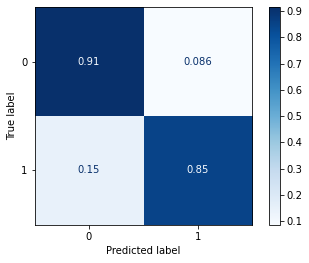


Métricas (val)
Matriz de confusión (val)


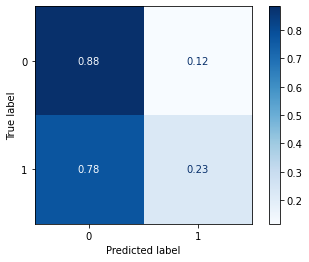

In [28]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          nb_detoxis
                         )

In [29]:
pos_class_prob_sorted = nb_detoxis.feature_log_prob_[1, :].argsort()[::-1]
palabras_odio_nb_detoxis = np.take(cv_detoxis.get_feature_names(), pos_class_prob_sorted[:100])
palabras_odio['detoxis_nb'] = pd.Series(palabras_odio_nb_detoxis)

if verbose_hate_words:
    print(palabras_odio_nb_detoxis)

In [30]:
# guardamos el vectorizador y los modelos entrenados

with open('docs/models/detoxis_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv_detoxis, file)

with open('docs/models/detoxis_lg_model.pkl', 'wb') as file:
    pickle.dump(lg_detoxis, file)

with open('docs/models/detoxis_nb_model.pkl', 'wb') as file:
    pickle.dump(nb_detoxis, file)

with open('docs/models/detoxis_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_detoxis, file)
    

## MeOffendMex dataset

In [31]:
cv_meoffendmex = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_meoffendmex = LogisticRegression(random_state=42)
nb_meoffendmex = ComplementNB()
rf_meoffendmex = RandomForestClassifier(random_state=42)

In [32]:
meoffendmex_corpus_lines = preprocess_corpus(meoffendmex['tweet:text'])

Tasa de aciertos del clasificador: 0.8972332015810277 (train), 0.7733860342555995 (val)

Métricas (train)
Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


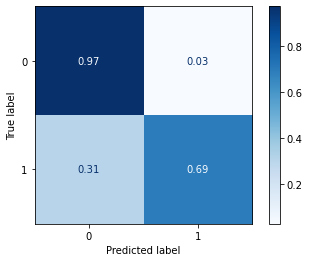


Métricas (val)
Matriz de confusión (val)


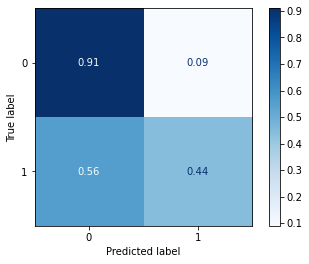

In [33]:
process_training_pipeline(meoffendmex_corpus_lines, 
                          cv_meoffendmex,
                          y_meoffendmex,
                          lg_meoffendmex
                         )

In [34]:
# TODO extracción de palabras de odio con log regression
#cv_meoffendmex


palabras_odio_lg_meoffendmex = []

Tasa de aciertos del clasificador: 0.8060417843026538 (train), 0.7575757575757576 (val)

Métricas (train)
Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


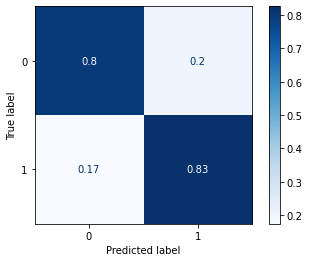


Métricas (val)
Matriz de confusión (val)


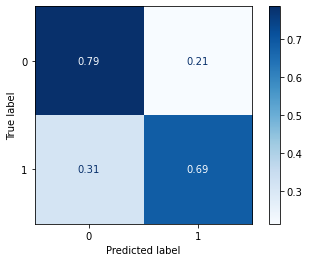

In [35]:
process_training_pipeline(meoffendmex_corpus_lines, 
                          cv_meoffendmex,
                          y_meoffendmex,
                          nb_meoffendmex
                         )

In [36]:
pos_class_prob_sorted = nb_meoffendmex.feature_log_prob_[1, :].argsort()[::-1]
palabras_odio_nb_meoffendmex = np.take(cv_meoffendmex.get_feature_names(), pos_class_prob_sorted[:100])
palabras_odio['meoffendmex_nb'] = pd.Series(palabras_odio_nb_meoffendmex)

if verbose:
    print(palabras_odio_nb_meoffendmex)

['el mundial' 'chilenos' 'por putos' 'prietas' 'como tu' 'mexicanos'
 'argentinos' 'gringos' 'mil putas' 'son unos' 'esperar' 'sabemos'
 'eres un' 'par' 'viernes' 'solo por' 'putito' 'putos hondureños' 'gordo'
 'ver si' 'hijo de tu' 'hondureños' 'la mierda' 'lo peor' 'lameculos'
 'por ser' 'tal vez' 'de sus putas' 'te voy' 'perra' 'tambien' 'te vas'
 'son bien' 'sabía' 'con tus' 'que putos' 'cuándo' 'de este'
 'tienen madre' 'hija de' 'de su puta' 'cago' 'carajo' 'realidad'
 'son putos' 'el joto' 'basura' 'esa golfa' 'el hdp' 'unos putos'
 'sus putas madres' 'siendo' 'trump' 'que feas' 'putos los' 'vieja'
 'viejas' 'los de' 'madre los' 'madre me' 'punto de' 'primero'
 'presidente' 'porno' 'váyanse' 'al mundial' 'pinche gorda' 'ya lo'
 'pienso' 'piensan' 'no sea' 'no tienen madre' 'argentina' 'aparte'
 'que bueno que' 'vete' 'vete la verga' 'vete la' 'azul' 'noerapenal'
 'deja de' 'moral' 'pinche joto' 'el culo' 'pasar' 'ir al' 'que quiero'
 'conozco' 'tantos' 'pela' 'de tu puta' 'polít

<ipython-input-11-18f507155129>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_tr, y_tr)


Tasa de aciertos del clasificador: 0.9988706945228685 (train), 0.7905138339920948 (val)

Métricas (train)
Matriz de confusión (train)


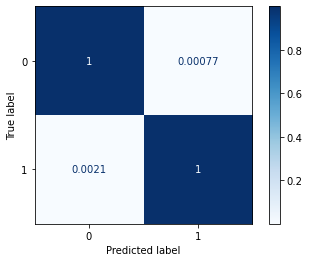


Métricas (val)
Matriz de confusión (val)


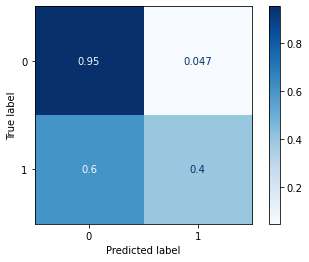

In [37]:
process_training_pipeline(meoffendmex_corpus_lines, 
                          cv_meoffendmex,
                          y_meoffendmex,
                          rf_meoffendmex
                         )

In [38]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_meoffendmex_idx = rf_meoffendmex.feature_importances_.argsort()[::-1]
palabras_odio_rf_meoffendmex = np.array(cv_meoffendmex.get_feature_names())[rf_features_meoffendmex_idx[:100]]
palabras_odio['meoffendmex_rf'] = pd.Series(palabras_odio_rf_meoffendmex)

if verbose:
    print(palabras_odio_rf_meoffendmex)

['hdp' 'pinche' 'tu' 'que' 'de' 'maricon' 'putos' 'la' 'me' 'joto' 'no'
 'son' 'el' 'en' 'pendejo' 'tu madre' 'los' 'se' 'hijo de' 'madre' 'loca'
 'es' 'por' 'pinches' 'te' 'ya' 'las' 'lo' 'hijo' 'un' 'verga' 'con'
 'para' 'vieja' 'golfa' 'prieta' 'lameculos' 'una' 'putas' 'su' 'mi'
 'como' 'eres' 'si' 'perra' 'pero' 'maricón' 'marica' 'la gorda' 'puto'
 'pendejos' 'puta' 'estoy' 'esta' 'gorda' 'de la' 'mundial' 'vete'
 'mierda' 'bien' 'más' 'hijos de' 'de mierda' 'le' 'del' 'pendeja' 'al'
 'les' 'yo' 'vas' 'prietas' 'jajajaja' 'hijos' 'solo' 'gordas'
 'hondureños' 'jajaja' 'él' 'chingar' 'cuando' 'todos' 'mil putas' 'ser'
 'trump' 'feas' 'ojalá' 'tu puta' 'qué' 'chilenos' 'tus' 'putita' 'viejas'
 'que no' 'porque' 'ni' 'culo' 'mujeres' 'chingas tu' 'que se' 'está']


In [39]:
# guardamos los modelos entrenados

with open('docs/models/meoffendmex_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv_meoffendmex, file)

with open('docs/models/meoffendmex_lg_model.pkl', 'wb') as file:
    pickle.dump(lg_meoffendmex, file)

with open('docs/models/meoffendmex_nb_model.pkl', 'wb') as file:
    pickle.dump(nb_meoffendmex, file)

with open('docs/models/meoffendmex_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_meoffendmex, file)
    

### Guardamos las palabras de odio

In [40]:
palabras_odio.to_csv('docs/palabras_odio.csv')

# Prueba de modelos en Reddit

In [41]:
df = pd.read_csv('docs/preprocessing_reddit_data.csv')

if verbose_dataset:
    print(df)

In [42]:
df_reddit_original = pd.read_csv('docs/preprocessing_reddit_data.csv')

In [43]:
reddit_corpus = preprocess_corpus(df['body'].astype('str'))

En base a los modelos previamente entrenados, usamos la siguiente función para detectar los comentarios de Reddit.

In [44]:
def predict_n_save_on_reddit_comments(cv, model, threshold, output_file_name):
    reddit_adapted = cv.transform(reddit_corpus)
    reddit_hs_proba = model.predict_proba(reddit_adapted)[:,1]
    hate_mask = reddit_hs_proba >= threshold
    print('Detectados {} comentarios de un total de {}'.format(np.shape(df_reddit_original[hate_mask])[0], np.shape(df_reddit_original)[0]))
    df_reddit_original[hate_mask].to_csv('docs/{}_hate.csv'.format(output_file_name))
    df_reddit_original[~hate_mask].to_csv('docs/{}_non_hate.csv'.format(output_file_name))

## A partir de modelos entrenados con HatEval

In [45]:
predict_n_save_on_reddit_comments(cv_hateval, nb_hateval, 0.8, 'test/test_reddit_hateval_hate_comments')

Detectados 2370 comentarios de un total de 27791


## A partir de modelos entrenados con Detoxis

In [46]:
predict_n_save_on_reddit_comments(cv_detoxis, nb_detoxis, 0.8, 'test/test_reddit_detoxis_hate_comments')

Detectados 1003 comentarios de un total de 27791


## A partir de modelos entrenados con MeOffendMex

In [47]:
predict_n_save_on_reddit_comments(cv_meoffendmex, nb_meoffendmex, 0.8, 'test/test_reddit_meoffendmex_hate_comments')

Detectados 2075 comentarios de un total de 27791


# Mejoras a realizar

* Optimizar híper-parámetros.
* Hacer un ensemble de clasificadores.
* **TODO**

FIN